In [1]:
#Source from Codebasics
#https://www.youtube.com/watch?v=bns5ELvbzVk
#Deep learning project end to end | Potato Disease Classification
#python version 3.7.11
#tensorflow version 2.6.0
#matplotlib 3.4.3

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
tf.__version__

'2.6.0'

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
#load the data using tensorflow dataset[tf.data.dataset] giving benefit of batches
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage dataset\color",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [8]:
68*32

2176

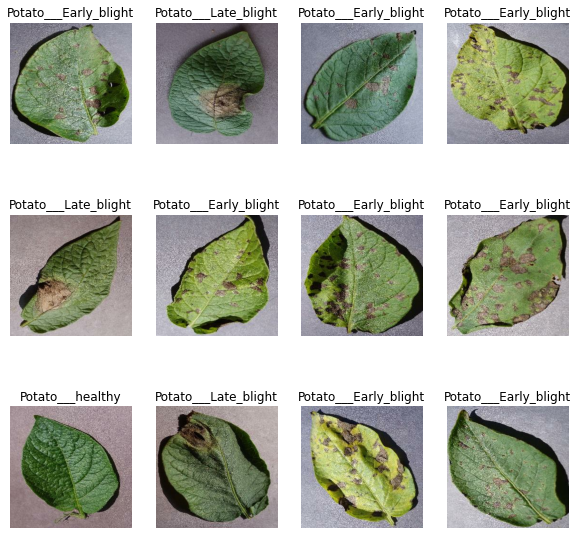

In [9]:
plt.figure(figsize=(10,10))#increasing the area of plot
#every element what i get here is a tensor, need to convert them to numpy 
for image_batch, label_batch in dataset.take(1):
    #summary info of one entire batch
    #print(image_batch.shape) # here image_batch, label_batch is a tensor
    #print(label_batch.numpy())
    #print(image_batch[0].shape)
    #print(image_batch[0])#its a tensor of first image
    #print(image_batch[0].numpy())#its a numpy of first image (nums bet 0 to 255)
    
    #visualization of image which takes the 3d array as input
    #plt.imshow(image_batch[0].numpy().astype("uint8"))
    #plt.title(class_names[label_batch[0]])
    #plt.axis("off")
    
    for i in range(12):
        plt.subplot(3,4,i+1)#showing multiple images
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
#spliting dataset into train test 80:10:10[training,validation,test]
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54) #its like slicing op arr[:54]
len(train_ds)

54

In [12]:
val_size = 0.1
rem_ds = dataset.skip(54) #its like arr[54:] which is 54 onwards
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = dataset.take(6)
len(val_ds)

6

In [14]:
test_ds = rem_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split = 0.8,val_split= 0.1,test_split = 0.1,shuffle = True,shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size) 
    
    return train_ds,val_ds,test_ds

In [16]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
len(train_ds)

54

In [20]:
#optimizing the datasets so tht the training will happen fast
#improving the performance by using tf pipeline() cache and prefetch()
#buffer_size will say how many batches to load in prefetch phase while GPU is training

train_ds =  train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds =  val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds =  test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
#Here one more thing is, we are creating some PREPROCESSING LAYERS whuch we will use 
#the time will create our model

#preprocessing the images RESIZE and RESCALING
#its done by TF apis otherwise we can do with numpy methods

#creating layer for resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

#Data Augmentation
#this can be done in two ways 1. using ImageDataGenerator api[keras.preprocessing.image]
#2.Tensorflow api
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
###MODEL BUILDING USING CNN
#number of layers in conv decided in Trail and error basis

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation ='relu'),
    layers.Dense(n_classes, activation = 'softmax'),
    
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [25]:
#accuracy is the metric which tracks our training process
model.compile(optimizer = 'adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
             metrics = ['accuracy'])


In [26]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1
)

Epoch 1/50
54/54 [==============================] - 145s 2s/step - loss: 0.9372 - accuracy: 0.4878 - val_loss: 0.8497 - val_accuracy: 0.5417
Epoch 2/50
54/54 [==============================] - 121s 2s/step - loss: 0.7569 - accuracy: 0.6117 - val_loss: 0.6816 - val_accuracy: 0.6250
Epoch 3/50
54/54 [==============================] - 124s 2s/step - loss: 0.4924 - accuracy: 0.7679 - val_loss: 0.4241 - val_accuracy: 0.8125
Epoch 4/50
54/54 [==============================] - 119s 2s/step - loss: 0.3934 - accuracy: 0.8304 - val_loss: 0.3799 - val_accuracy: 0.8490
Epoch 5/50
54/54 [==============================] - 124s 2s/step - loss: 0.3453 - accuracy: 0.8600 - val_loss: 0.4162 - val_accuracy: 0.8438
Epoch 6/50
54/54 [==============================] - 118s 2s/step - loss: 0.2739 - accuracy: 0.8935 - val_loss: 0.2717 - val_accuracy: 0.9062
Epoch 7/50
54/54 [==============================] - 119s 2s/step - loss: 0.2333 - accuracy: 0.9045 - val_loss: 0.3622 - val_accuracy: 0.8854
Epoch 8/50
54

In [28]:
#chking on the test dataset
scores = model.evaluate(test_ds)

8/8 [==============================] - 25s 610ms/step - loss: 0.0401 - accuracy: 0.9805


In [29]:
scores #list[loss,accuracy]

[0.04008395969867706, 0.98046875]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
history.history['accuracy']

[0.4878472089767456,
 0.6116898059844971,
 0.7679398059844971,
 0.8304398059844971,
 0.8599537014961243,
 0.8935185074806213,
 0.9045138955116272,
 0.9201388955116272,
 0.9322916865348816,
 0.9097222089767456,
 0.9363425970077515,
 0.9340277910232544,
 0.9519675970077515,
 0.9479166865348816,
 0.9467592835426331,
 0.9646990895271301,
 0.9693287014961243,
 0.9849537014961243,
 0.9699074029922485,
 0.9785879850387573,
 0.984375,
 0.9785879850387573,
 0.9722222089767456,
 0.9855324029922485,
 0.9826388955116272,
 0.9803240895271301,
 0.9699074029922485,
 0.9820601940155029,
 0.9878472089767456,
 0.984375,
 0.9849537014961243,
 0.984375,
 0.9930555820465088,
 0.9878472089767456,
 0.9866898059844971,
 0.9756944179534912,
 0.9907407164573669,
 0.9907407164573669,
 0.9866898059844971,
 0.9785879850387573,
 0.9884259104728699,
 0.9930555820465088,
 0.9890046119689941,
 0.984375,
 0.9947916865348816,
 0.9895833134651184,
 0.9965277910232544,
 0.9982638955116272,
 0.9826388955116272,
 0.99768519

In [37]:
import pandas as pd

#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

#loss = history.history['loss']
#val_loss = history.history['val_loss']

history_df = pd.DataFrame(history.history)

<AxesSubplot:title={'center':'Accuracy'}>

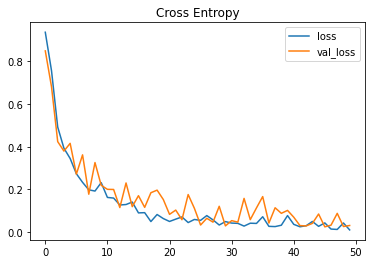

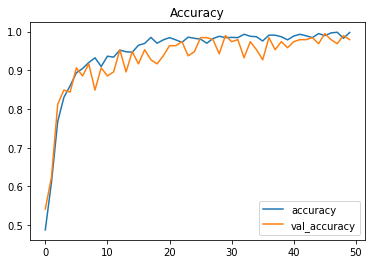

In [41]:
#plt.figure(figsize = (8,8))
#plt.subplot(1,2,1)
#plt.plot(range(EPOCHS),acc,label = 'Training Accuracy')
#plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
#plt.legend(loc = 'lower right')
#plt.title('Training and Validation Accuracy')

history_df.loc[:, ['loss','val_loss']].plot(title="Cross Entropy")
history_df.loc[:, ['accuracy','val_accuracy']].plot(title="Accuracy")

the actual label : Potato___Early_blight
Potato___Early_blight


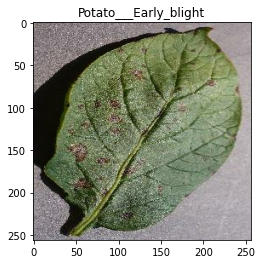

In [50]:
import numpy as np
#MAKING PREDICTIONS
#checking with single image
for images_batch, labels_batch in test_ds.take(1):
    plt.imshow(images_batch[0].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[0]])
    actual_label = class_names[labels_batch[0]]
    
    print("the actual label :",actual_label)
    pred_batch = model.predict(images_batch)
    print(class_names[np.argmax(pred_batch[0])])
    

In [53]:
def prediction(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class,confidence

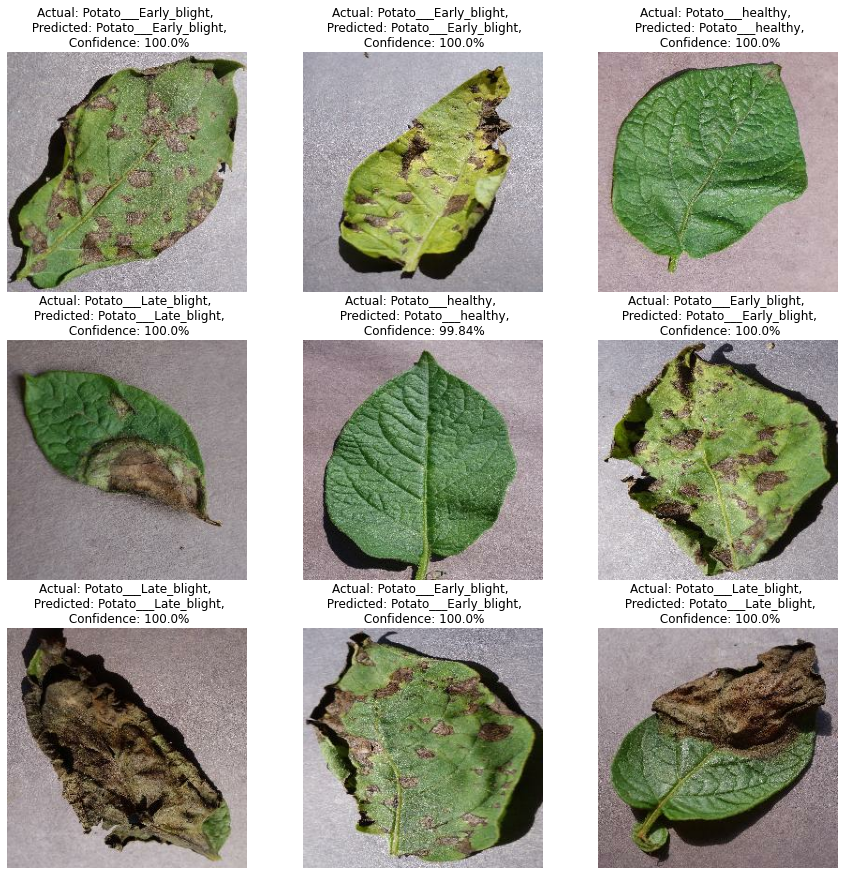

In [66]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class,confidence = prediction(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")
        

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

true_val = 
pred_val = model.predict(test_ds)
print(classfication_report(true_val,pred_val,target_names=class_names))

In [71]:
import os
model_version = max([int(i) for i in os.listdir("../models") +[0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets
